<a href="https://colab.research.google.com/github/LeonBrasseler/PINN_playground/blob/main/PINN_osci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# !pip install torch
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 14.2 MB/s eta 0:00:00


In [8]:
# import tensorflow.compat.v1 as tf
# tf.enable_eager_execution()
import os
os.environ["DDE_BACKEND"] = "pytorch"

import deepxde as dde
dde.config.set_default_float("float64")
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
if torch.cuda.is_available():
    print("CUDA available")
    torch.set_default_device("cuda")
    device = torch.device("cuda")
else:
    print("CUDA *not* available")
    device = torch.device("cpu")
os.environ["DDE_BACKEND"] = "pytorch"
backend = os.environ["DDE_BACKEND"]
print(backend)

Set the default float type to float64
CUDA available
pytorch


In [16]:
def net(input, output, hidden, num_hidden):
  net = dde.nn.FNN([input] + [hidden] * num_hidden + [output], "tanh", "Glorot uniform",
                  #  regularization="l2"
                   )
  return net

In [11]:
# Constants
d, w0 = torch.as_tensor([2.0], device=device), torch.as_tensor([20.0], device=device)
mu, k = 2.0*d, w0**2.0
m = torch.as_tensor([1.], device=device)
# print(d.device)

In [12]:
# @tf.function
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = torch.sqrt(w0**2-d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2.*torch.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2.*A*cos
    return u

In [13]:
# Define the residual
# @tf.function
def residual(input, output):
  dxdt = dde.grad.jacobian(output, input, i=0)
  dx2dt2 = dde.grad.jacobian(dxdt, input, i=0)

  return torch.as_tensor(m * dx2dt2 + mu * dxdt + k * output)

In [14]:
time_domain = dde.geometry.TimeDomain(0, 2)

# def boundary_t(t, on_boundary):
    # return on_boundary and dde.utils.isclose(t[0], 0)
# def boundary_l(x, on_boundary):
    # return on_boundary and dde.utils.isclose(x[0], 0)
# def funcN(x):
    # return torch.as_tensor([0.0], device=device).view(-1,1).requires_grad_(True)
# def funcD(x):
    # return torch.as_tensor([1.0], device=device).view(-1,1).requires_grad_(True)
bc_l = dde.icbc.NeumannBC(time_domain, lambda x: 0, lambda t, on_boundary: on_boundary and dde.utils.isclose(t[0], 0))
bc_r = dde.icbc.IC(time_domain, lambda x: 1, lambda _, on_initial: on_initial)

In [17]:
# tf.random.set_seed(123)

# define a neural network to train
pinn = net(1,1,hidden=75,num_hidden=4)
# define boundary points, for the boundary loss
# t_boundary = tf.constant(0.)

# define training points over the entire domain, for the physics loss
# t_physics = tf.linspace(0,1,30)

# train the PINN

In [18]:
def custom_loss(y_true, y_pred):
    # print(y_true.shape)
    # print(y_pred.shape)
    loss = torch.mean((y_true - y_pred)**2)
    # print(loss.shape)
    return loss

In [20]:
data = dde.data.TimePDE(time_domain, residual, [bc_l, bc_r], num_domain=1000,
                        num_boundary=10, num_test=30)
model = dde.Model(data, pinn)
# model.outputs_modify(lambda x, y: x * y)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
model.compile(optimizer=optimizer, loss_weights=[1e-4, 1e-1, 1],
              loss=lambda y_true, y_pred: custom_loss(y_true, y_pred))

Compiling model...


AttributeError: 'Sequential' object has no attribute 'regularizer'

In [ ]:
losshistory, train_state = model.train(iterations=6000)
# model.compile("L-BFGS")
# losshistory, train_state = model.train()

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.12e+00, 2.63e-02, 1.00e+00]    [4.10e+00, 2.63e-02, 1.00e+00]    []  
1000      [7.18e-02, 3.54e-05, 8.50e-03]    [6.24e-02, 3.54e-05, 8.50e-03]    []  
2000      [8.12e-02, 3.15e-02, 3.98e-03]    [7.95e-02, 3.15e-02, 3.98e-03]    []  
3000      [3.57e-02, 1.82e-03, 1.33e-03]    [4.35e-02, 1.82e-03, 1.33e-03]    []  
4000      [2.76e-02, 8.75e-03, 1.00e-03]    [2.98e-02, 8.75e-03, 1.00e-03]    []  
5000      [1.10e-02, 5.73e-04, 1.78e-04]    [1.13e-02, 5.73e-04, 1.78e-04]    []  
6000      [1.04e-02, 2.13e-03, 9.65e-05]    [1.05e-02, 2.13e-03, 9.65e-05]    []  

Best model at step 5000:
  train loss: 1.17e-02
  test loss: 1.20e-02
  test metric: []

'train' took 52.734526 s



Saving loss history to C:\Users\LeonB\Desktop\MA\PINN_playground\loss.dat ...
Saving training data to C:\Users\LeonB\Desktop\MA\PINN_playground\train.dat ...
Saving test data to C:\Users\LeonB\Desktop\MA\PINN_playground\test.dat ...


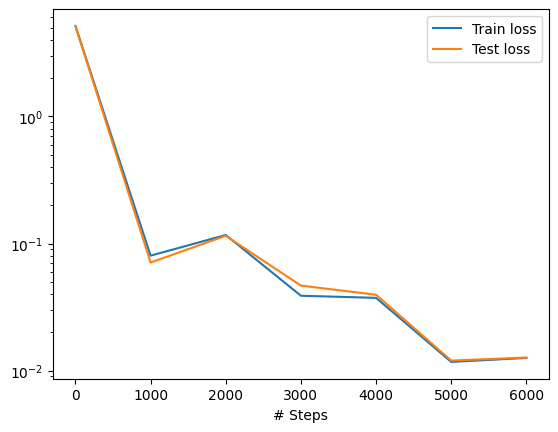

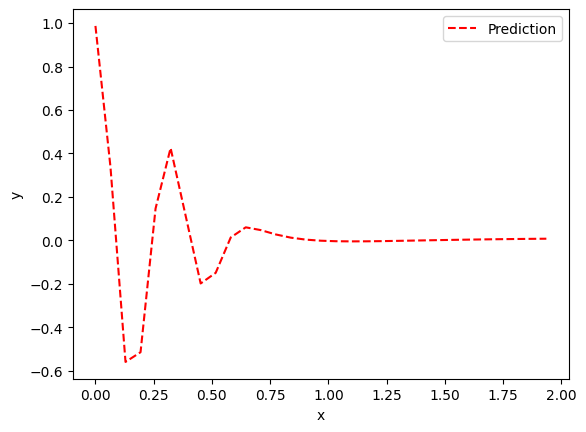

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

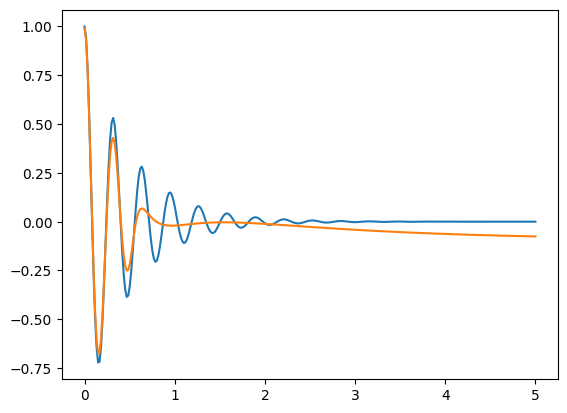

In [ ]:
import matplotlib.pyplot as plt
t_test = torch.linspace(0,5,300, device=device).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
t_test = t_test.cpu().numpy()
u_exact = u_exact.cpu().numpy()
u_pred = model.predict(t_test)
plt.plot(t_test, u_exact)
plt.plot(t_test, u_pred)
plt.show()